In [1]:
import time

# Your choice of plotting front-end.
%matplotlib inline

import ROOT
tcanvas = ROOT.TCanvas("TCanvasName", "TCanvasTitle", 800, 300)

Welcome to JupyROOT 6.08/05


In [2]:
tchain = ROOT.TChain()
tchain.Add("root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_0.root/tree")
tchain.Add("root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_1.root/tree")
tchain.Add("root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_2.root/tree")
tchain.Add("root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_3.root/tree")
tchain.Add("root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_4.root/tree")
list(tchain.GetListOfBranches())

[<ROOT.TBranch object ("ph_N") at 0x762b670>,
 <ROOT.TBranchElement object ("ph_pdgId") at 0x7635c30>,
 <ROOT.TBranchElement object ("ph_charge") at 0x763e240>,
 <ROOT.TBranchElement object ("ph_e") at 0x763e950>,
 <ROOT.TBranchElement object ("ph_eta") at 0x763f060>,
 <ROOT.TBranchElement object ("ph_phi") at 0x763f770>,
 <ROOT.TBranchElement object ("ph_mass") at 0x763fe80>,
 <ROOT.TBranchElement object ("ph_pt") at 0x7640590>,
 <ROOT.TBranchElement object ("ph_et") at 0x7640ca0>,
 <ROOT.TBranchElement object ("ph_rho") at 0x76413b0>,
 <ROOT.TBranchElement object ("ph_superCluster_eta") at 0x7641ac0>,
 <ROOT.TBranchElement object ("ph_superCluster_phi") at 0x7642260>,
 <ROOT.TBranchElement object ("ph_sigmaIetaIeta") at 0x7642a30>,
 <ROOT.TBranchElement object ("ph_hOverE") at 0x7643200>,
 <ROOT.TBranchElement object ("ph_isoGamma") at 0x7643910>,
 <ROOT.TBranchElement object ("ph_isoCh") at 0x7644020>,
 <ROOT.TBranchElement object ("ph_passEleVeto") at 0x7644730>,
 <ROOT.TBranchElem

In [3]:
tchain.SetBranchStatus("*", 0)
for branch in ["jetAK4_N",
               "jetAK4_pt",
               "jetAK4_eta",
               "jetAK4_mass",
               "jetAK4_phi",
               "jetAK4_e",
               "jetAK4_jec",
               "jetAK4_IDLoose"]:
    tchain.SetBranchStatus(branch, 1)

In [4]:
dijetMass_hist = ROOT.TH1D("dijetMass_hist", "dijet mass [GeV]", 100, 0, 1000)
dijetEtBalance_hist = ROOT.TH1D("dijetEtBalance_hist", "dijet ET balance", 100, 0, 1)
cosThetaStar_hist = ROOT.TH1D("cosThetaStar_hist", "cos(theta*)", 100, -1, 1)

leadingJet = ROOT.TLorentzVector()
subleadingJet = ROOT.TLorentzVector()

startTime = time.time()
for event in tchain:
    if event.jetAK4_N < 2:
        continue
    
    leadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(0),
                            event.jetAK4_eta.at(0),
                            event.jetAK4_phi.at(0),
                            event.jetAK4_e.at(0))
    
    subleadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(1),
                               event.jetAK4_eta.at(1),
                               event.jetAK4_phi.at(1),
                               event.jetAK4_e.at(1))
    
    dijet = leadingJet + subleadingJet

    boostedLeadingJet = leadingJet
    boostedLeadingJet.Boost(-dijet.BoostVector())
    
    dijetMass_hist.Fill(dijet.M())
    dijetEtBalance_hist.Fill(subleadingJet.Et() / leadingJet.Et())
    cosThetaStar_hist.Fill(boostedLeadingJet.Pz() / boostedLeadingJet.P())

endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 17.0815181732 seconds.


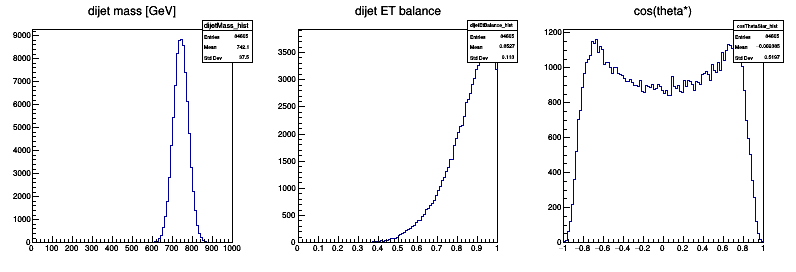

In [5]:
tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist.Draw()
tcanvas.cd(2); dijetEtBalance_hist.Draw()
tcanvas.cd(3); cosThetaStar_hist.Draw()
tcanvas.Draw()

In [6]:
from histogrammar import *

Bundle = UntypedLabel    # a naming convention we'll be changing to in Histogrammar 2.0

def cosThetaStar(jets):
    boostedLeading = jets[0]
    boostedLeading.Boost(-(jets[0] + jets[1]).BoostVector())
    return boostedLeading.Pz() / boostedLeading.P()

histograms = Bundle(
    dijetMass      = Bin(100, 0, 1000, lambda jets: (jets[0] + jets[1]).M()),
    dijetEtBalance = Bin(100, 0, 1, lambda jets: jets[1].Et() / jets[0].Et()),
    cosThetaStar   = Bin(100, -1, 1, cosThetaStar))

leadingJet = ROOT.TLorentzVector()
subleadingJet = ROOT.TLorentzVector()

startTime = time.time()
for event in tchain:
    if event.jetAK4_N < 2:
        continue
    
    leadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(0),
                            event.jetAK4_eta.at(0),
                            event.jetAK4_phi.at(0),
                            event.jetAK4_e.at(0))
    
    subleadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(1),
                               event.jetAK4_eta.at(1),
                               event.jetAK4_phi.at(1),
                               event.jetAK4_e.at(1))
    
    histograms.fill([leadingJet, subleadingJet])

endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 24.3862490654 seconds.


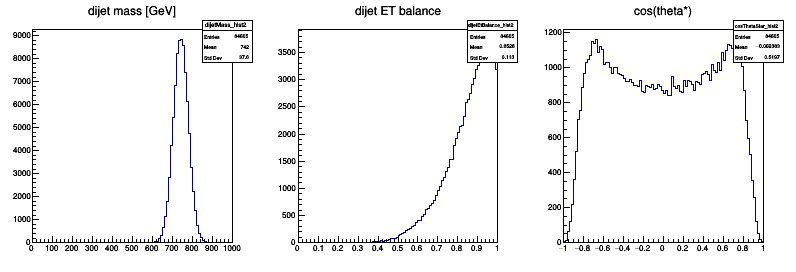

In [7]:
dijetMass_hist2 = histograms.get("dijetMass").plot.root("dijetMass_hist2", "dijet mass [GeV]")
dijetEtBalance_hist2 = histograms.get("dijetEtBalance").plot.root("dijetEtBalance_hist2", "dijet ET balance")
cosThetaStar_hist2 = histograms.get("cosThetaStar").plot.root("cosThetaStar_hist2", "cos(theta*)")

tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist2.Draw()
tcanvas.cd(2); dijetEtBalance_hist2.Draw()
tcanvas.cd(3); cosThetaStar_hist2.Draw()
tcanvas.Draw()

In [10]:
ROOT.gInterpreter.Declare("""
TLorentzVector leadingJet;
TLorentzVector subleadingJet;
TLorentzVector dimuon;
TLorentzVector boostedLeadingJet;

bool update(vector<float>& pt, vector<float>& eta, vector<float>& phi, vector<float>& e) {
    leadingJet.SetPtEtaPhiE(pt.at(0), eta.at(0), phi.at(0), e.at(0));
    subleadingJet.SetPtEtaPhiE(pt.at(1), eta.at(1), phi.at(1), e.at(1));
    dimuon = leadingJet + subleadingJet;
    boostedLeadingJet.SetPtEtaPhiE(pt.at(0), eta.at(0), phi.at(0), e.at(0));
    boostedLeadingJet.Boost(-dimuon.BoostVector());
    return true;
}
""")

True

In [11]:
histograms = Select("jetAK4_N >= 2  &&  update(jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e)", Bundle(
    dijetMass      = Bin(100, 0, 1000, "dimuon.M()"),
    dijetEtBalance = Bin(100, 0, 1,    "subleadingJet.Et() / leadingJet.Et()"),
    cosThetaStar   = Bin(100, -1, 1,   "boostedLeadingJet.Pz() / boostedLeadingJet.P()")
))

startTime = time.time()
histograms.fill.root(tchain)
endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 1.24155902863 seconds.


In [12]:
# yes, we're creating new TLorentzVectors, but we're creating them on the stack (no "new" operator), which is fast
ROOT.gInterpreter.Declare("""
TLorentzVector lorentzVector(int which,
                             vector<float>& pt,
                             vector<float>& eta,
                             vector<float>& phi,
                             vector<float>& e) {
    TLorentzVector out;
    out.SetPtEtaPhiE(pt.at(which), eta.at(which), phi.at(which), e.at(which));
    return out;
}
""")

ROOT.gInterpreter.Declare("""
double cosThetaStar(TLorentzVector leadingJet, TLorentzVector subleadingJet) {
    leadingJet.Boost(-(leadingJet + subleadingJet).BoostVector());
    return leadingJet.Pz() / leadingJet.P();
}
""")

True

In [13]:
histograms = Select("jetAK4_N >= 2", Bundle(
    dijetMass = Bin(100, 0, 1000, """
        (lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e) +
         lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e)
        ).M()
    """),
    dijetEtBalance = Bin(100, 0, 1, """
        lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e).Et() /
        lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e).Et()
    """),
    cosThetaStar   = Bin(100, -1, 1, """cosThetaStar(
        lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e),
        lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e))""")
))

startTime = time.time()
histograms.fill.root(tchain)
endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 0.946064949036 seconds.


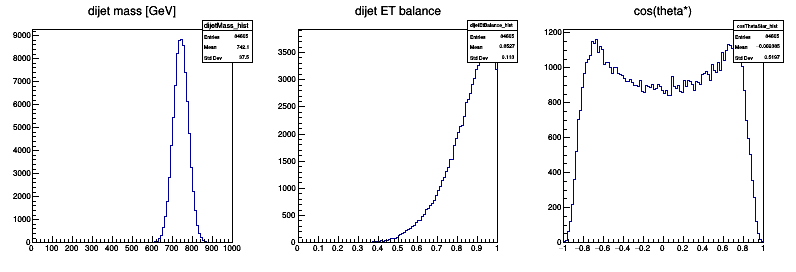

In [14]:
dijetMass_hist3 = histograms.get("dijetMass").plot.root("dijetMass_hist3", "dijet mass [GeV]")
dijetEtBalance_hist3 = histograms.get("dijetEtBalance").plot.root("dijetEtBalance_hist3", "dijet ET balance")
cosThetaStar_hist3 = histograms.get("cosThetaStar").plot.root("cosThetaStar_hist3", "cos(theta*)")

tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist.Draw()
tcanvas.cd(2); dijetEtBalance_hist.Draw()
tcanvas.cd(3); cosThetaStar_hist.Draw()
tcanvas.Draw()